# Notebook

In this notebook we explore the application of different pre-trained models with fine-tunning on our dataset for the purpose of multi-class text classification. We will use the `transformers` library by Hugging Face to load the pre-trained models.

## Setting up

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import warnings
import time

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from datasets import Dataset
from datasets import DatasetDict
from datasets import load_metric

from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import TextClassificationPipeline
from transformers import pipeline

# from peft import get_peft_model, LoraConfig, TaskType # uncomment this line if you want to use LoRA

# suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\sanct\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_pickle("data/data_original.pkl")

down_sample_percentage = 5

# down sample data
df = df.sample(frac=down_sample_percentage/100, random_state=1)

# rename emotions to label and map to integers
df.rename(columns={'emotions':'label'}, inplace = True)
label_map = {"sadness": 0, "joy": 1, "love": 2, "anger": 3, "fear": 4, "surprise": 5} 
df['label'] = df['label'].map(label_map)

print(df.shape)
df.head()

(20840, 2)


,text,label
98790,i wanted them to feel now i feel as though i a...,0
18398,i found myself feeling very sympathetic toward...,2
139349,ive been feeling pretty good today and tonight...,1
13416,i can use to cover my ass when i feel inadequate,0
22297,i feel like ive pissed myself again,3


In [3]:
dataset = Dataset.from_pandas(df)

# 80% train, 20% test+validation
train_test = dataset.train_test_split(test_size=0.2)

# Split the 10% test+validation set in half test, half validation
valid_test = train_test['test'].train_test_split(test_size=0.5)

# gather everyone if you want to have a single DatasetDict
train_valid_test_dataset = DatasetDict({
    'train': train_test['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

print(train_valid_test_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 16672
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2084
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2084
    })
})


## Fine-tuning a pre-trained Hugging Face model

We need to load:
- the pre-trained model itself
- the tokenizer associated with the model (used to preprocess the data)

In [4]:
model_name = "distilbert-base-uncased"

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# The second option is to use our own distilbert model that we have trained because of the domain adaptation
# Load the model from the folder ./domain-model/distilbert-emotions
# model = AutoModelForSequenceClassification.from_pretrained("domain-model/distilbert-emotions", num_labels=6)
# tokenizer = AutoTokenizer.from_pretrained("domain-model/distilbert-emotions")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at domain-model/distilbert-emotions and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We can try to use LoRA to perform the fine-tuning of the model.

In [6]:
# Set up LoRA configuration for distilbert-base-uncased model
# config = LoraConfig(
#     r=32,  # Rank of the low-rank matrices
#     lora_alpha=32,
##     we tried different configuration values besides the one present here    
#     target_modules = [
#         'transformer.layer.0.attention.q_lin',
#         'transformer.layer.0.attention.k_lin',
#         'transformer.layer.0.attention.v_lin',
#         'transformer.layer.0.attention.out_lin',
#     ],
#     task_type=TaskType.SEQ_CLS,  # Task type for sequence classification
#     lora_dropout=0.1
# )

# model = get_peft_model(model, config)

### Pre-processing the data with the tokenizer

In [7]:
def preprocess_function(sample):
    return tokenizer(sample["text"], padding=True, truncation=True, return_tensors="pt")

tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

print(tokenized_dataset)

Map: 100%|██████████| 2084/2084 [00:00<00:00, 21051.32 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 16672
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 2084
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 2084
    })
})


### Model training (Fine-tuning)

In [9]:
def predict(text):
    global model, tokenizer
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=1)
    print(predictions)
    predicted_class = torch.argmax(predictions)
    name = [i for i, j in label_map.items() if j == predicted_class.item()][0]
    print(f"Predicted class: {name}")
    
# predict("I'm so sad")

In [10]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [11]:
trainer.evaluate()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 131/131 [00:25<00:00,  5.18it/s]


{'eval_loss': 1.7818537950515747,
 'eval_accuracy': 0.30374280230326295,
 'eval_runtime': 25.5354,
 'eval_samples_per_second': 81.612,
 'eval_steps_per_second': 5.13}

In [12]:
start = time.time()
trainer.train()
end = time.time()
print(f"Training time: {(end - start)/60} minutes")

 16%|█▌        | 500/3126 [07:48<42:07,  1.04it/s]

{'loss': 0.722, 'learning_rate': 1.6801023672424827e-05, 'epoch': 0.48}


 32%|███▏      | 1000/3126 [15:37<29:20,  1.21it/s]

{'loss': 0.2424, 'learning_rate': 1.3602047344849649e-05, 'epoch': 0.96}


                                                   
 33%|███▎      | 1042/3126 [16:41<33:45,  1.03it/s]Checkpoint destination directory ./results\checkpoint-1042 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.17943193018436432, 'eval_accuracy': 0.9294625719769674, 'eval_runtime': 24.0062, 'eval_samples_per_second': 86.811, 'eval_steps_per_second': 5.457, 'epoch': 1.0}


 48%|████▊     | 1500/3126 [23:34<25:13,  1.07it/s]  

{'loss': 0.1636, 'learning_rate': 1.0403071017274472e-05, 'epoch': 1.44}


 64%|██████▍   | 2000/3126 [31:02<15:52,  1.18it/s]

{'loss': 0.1558, 'learning_rate': 7.204094689699297e-06, 'epoch': 1.92}


                                                   
 67%|██████▋   | 2084/3126 [32:42<16:46,  1.04it/s]Checkpoint destination directory ./results\checkpoint-2084 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.14907459914684296, 'eval_accuracy': 0.9385796545105566, 'eval_runtime': 24.6496, 'eval_samples_per_second': 84.545, 'eval_steps_per_second': 5.314, 'epoch': 2.0}


 80%|███████▉  | 2500/3126 [39:14<09:19,  1.12it/s]  

{'loss': 0.1127, 'learning_rate': 4.005118362124121e-06, 'epoch': 2.4}


 96%|█████████▌| 3000/3126 [46:45<01:55,  1.09it/s]

{'loss': 0.0989, 'learning_rate': 8.061420345489445e-07, 'epoch': 2.88}


                                                   
100%|██████████| 3126/3126 [49:05<00:00,  1.06it/s]Checkpoint destination directory ./results\checkpoint-3126 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.14190995693206787, 'eval_accuracy': 0.9404990403071017, 'eval_runtime': 23.9929, 'eval_samples_per_second': 86.859, 'eval_steps_per_second': 5.46, 'epoch': 3.0}


100%|██████████| 3126/3126 [49:06<00:00,  1.06it/s]

{'train_runtime': 2946.2399, 'train_samples_per_second': 16.976, 'train_steps_per_second': 1.061, 'train_loss': 0.24290280485488785, 'epoch': 3.0}
Training time: 49.105548934141794 minutes


In [13]:
trainer.evaluate()

100%|██████████| 131/131 [00:24<00:00,  5.44it/s]


{'eval_loss': 0.14190995693206787,
 'eval_accuracy': 0.9404990403071017,
 'eval_runtime': 24.3021,
 'eval_samples_per_second': 85.754,
 'eval_steps_per_second': 5.39,
 'epoch': 3.0}

In [14]:
trainer.predict(test_dataset=tokenized_dataset["test"])

100%|██████████| 131/131 [00:24<00:00,  5.28it/s]


PredictionOutput(predictions=array([[-2.0043402 , -2.6300287 , -2.1184978 , -1.8301985 ,  5.4808497 ,
        -1.3891222 ],
       [ 6.839966  , -1.1959943 , -1.7989926 , -1.7682564 , -1.4959844 ,
        -2.7056172 ],
       [-2.282832  ,  6.6406794 , -0.98527825, -3.3657422 , -2.7835832 ,
        -1.2812519 ],
       ...,
       [-2.0898328 ,  6.6726036 , -1.2878399 , -2.83791   , -2.3175964 ,
        -2.1326015 ],
       [-2.2890491 ,  1.9566128 ,  4.7658114 , -2.9769497 , -2.9978685 ,
        -2.6447442 ],
       [ 2.7413702 , -2.1416805 , -3.1618237 , -2.4354289 ,  3.5420938 ,
        -1.8753939 ]], dtype=float32), label_ids=array([4, 0, 1, ..., 1, 2, 0], dtype=int64), metrics={'test_loss': 0.1729297637939453, 'test_accuracy': 0.9294625719769674, 'test_runtime': 25.0328, 'test_samples_per_second': 83.251, 'test_steps_per_second': 5.233})

### Save & Load Model

In [15]:
trainer.save_model()

tokenizer2 = AutoTokenizer.from_pretrained("./results")
model2 = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=6)

pipe = TextClassificationPipeline(model=model2, tokenizer=tokenizer2) #, return_all_scores=True)

# pipe("I love this place!")
# pipe("Paris was very disappointing")

### Evaluate Model Results

In [16]:
def show_cm(cm, classes, figsize=(10, 10)):
    # cm = np.array([[TP, FP], [FN, TN]])
    plt.figure(figsize=figsize)
    plt.imshow(cm)
    plt.suptitle('Confusion matrix')
    total = sum(sum(cm))
    plt.title('Total cases: {}'.format(total))
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            perc = round(cm[i, j] / total * 100, 1)
            plt.text(j, i, f"{format(cm[i, j], '.0f')} : {perc}%", horizontalalignment="center",
                     color="black" if cm[i, j] > cm.max() / 2 else "white")

    plt.show()

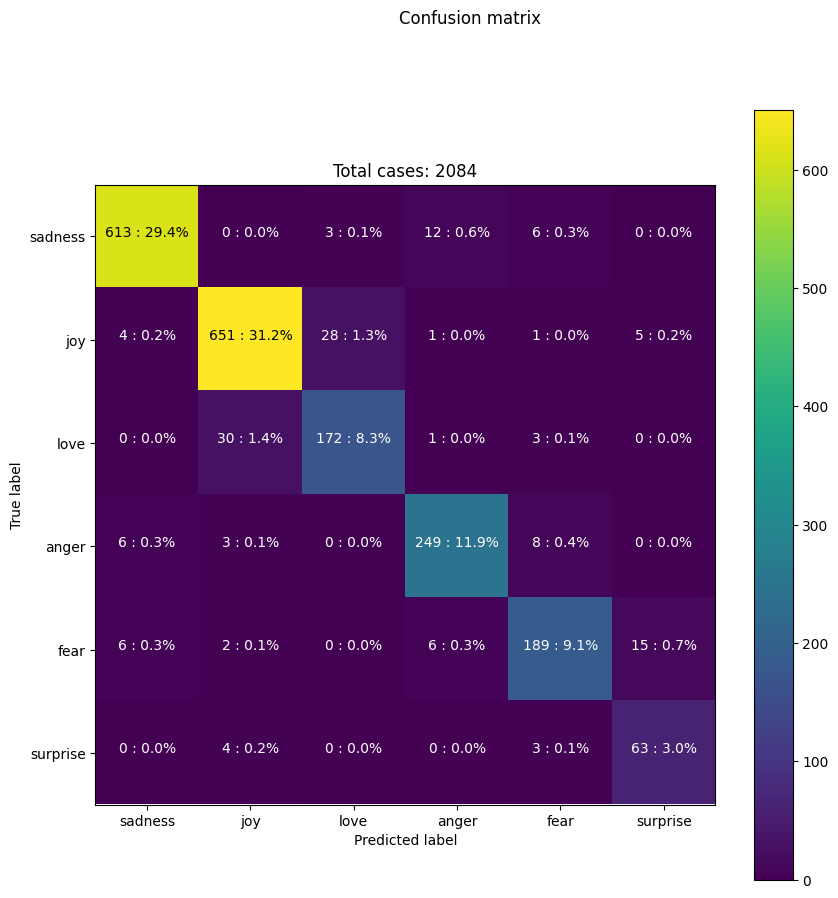

Accuracy:  0.9294625719769674
Precision:  0.8916697335924991
Recall:  0.9080615652362013
F1:  0.8988011383768906


In [17]:
y_pred= []
for p in tokenized_dataset['test']['text']:
    ti = tokenizer2(p, return_tensors="pt")
    out = model2(**ti)
    pred = torch.argmax(out.logits)
    y_pred.append(pred)
    
y_test = tokenized_dataset['test']['label']

show_cm(confusion_matrix(y_test, y_pred), label_map.keys())
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='macro'))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))
print('F1: ', f1_score(y_test, y_pred, average='macro'))